# Milestone 1 (7th April, 5pm)
10% of the final grade

This is a preliminary milestone to let you set up goals for your final project and assess the feasibility of your ideas. Please, fill the following sections about your project.

(max. 2000 characters per section)

# Dataset
Find a dataset (or multiple) that you will explore. Assess the quality of the data it contains and how much preprocessing / data-cleaning it will require before tackling visualization. We recommend using a standard dataset as this course is not about scraping nor data processing.

Hint: some good pointers for finding quality publicly available datasets (Google dataset search, Kaggle, OpenSwissData, SNAP and FiveThirtyEight), you could use also the DataSets proposed by the ENAC (see the Announcements section on Zulip).

# Problematic
Frame the general topic of your visualization and the main axis that you want to develop.

What am I trying to show with my visualization?
Think of an overview for the project, your motivation, and the target audience.
# Exploratory Data Analysis
Pre-processing of the data set you chose

Show some basic statistics and get insights about the data
# Related work
What others have already done with the data?
Why is your approach original?
What source of inspiration do you take? Visualizations that you found on other websites or magazines (might be unrelated to your data).
In case you are using a dataset that you have already explored in another context (ML or ADA course, semester project...), you are required to share the report of that work to outline the differences with the submission for this class.

# Dataset

The dataset we're going to use is Friends Corpus (available here: https://convokit.cornell.edu/documentation/friends.html), a collection of the scripts of the a worldwide famous TV series Friends, collecting every utterance of the series.

This dataset is already very valuable to us, and won't need any data cleaning, as it's already organized in three ways:
 - Speaker-level information: we can filter the data based on a speakers' set, where speakers are characters of the series with a special speaker TRANSCRIPT_NODE for utterances not related to a speaker speaking (e.g. [Rachel stands up])
 - Utterance-level information: utterances provide various information. An id to identify them based on the season, episode, scene and # of utterance, the speaker, the utterance that he's replying to, the id of the conversation it belongs to, and the content of the utterance.
 - Conversation-level information: as mentioned at the link above, 'Conversations represent scenes of the show. They are indexed by the id sXX-eYY-cZZ, where XX denotes the season (e.g. 01), YY denotes the episode (e.g. 01), ZZ denotes the conversation (e.g. 01)'

# Problematic

We want to have a way for the passionates of the series to see how the characters interact between them. The core of our project will be to project how the utterances are related to the conversations and in particular to the speakers.

We want to show different graphs all related between them, where the user can interact with the a graph and the same time be able to see how it moves the other graphs related to it. This is likely going to be the hardest part of the project, as we will have to structure a way to relate the utterance, conversation and speakers, all in ones, and it will likely require some time to compute everything.

# Exploratory Data Analysis
We import everything and plot a first visual sketch of the values of our dataset

In [67]:
import pandas as pd
import matplotlib.pyplot as plt
import networkx as nx
import seaborn as sns
import numpy as np
import nltk
from nltk.corpus import stopwords
from wordcloud import WordCloud
from collections import Counter
from convokit import Corpus, download
import itertools
import warnings
warnings.filterwarnings('ignore')

In [59]:
# Download the dataset
corpus = Corpus(filename=download("friends-corpus"))

Dataset already exists at C:\Users\mateo\.convokit\downloads\friends-corpus


In [60]:
corpus.print_summary_stats()

Number of Speakers: 700
Number of Utterances: 67373
Number of Conversations: 3107


In [61]:
df = corpus.get_utterances_dataframe().reset_index()

In [62]:
df['season'] = df['id'].apply(lambda x: int(x.split("_")[0][1:]))
df['episode'] = df['id'].apply(lambda x: int(x.split("_")[1][1:]))
df['chapter'] = df['id'].apply(lambda x: int(x.split("_")[2][1:]))
df['utterance'] = df['id'].apply(lambda x: int(x.split("_")[3][1:]))

In [63]:
df.head()

id timestamp  \
0  s01_e01_c01_u001      None   
1  s01_e01_c01_u002      None   
2  s01_e01_c01_u003      None   
3  s01_e01_c01_u004      None   
4  s01_e01_c01_u005      None   

                                                text          speaker  \
0  There's nothing to tell! He's just some guy I ...    Monica Geller   
1  C'mon, you're going out with the guy! There's ...   Joey Tribbiani   
2  All right Joey, be nice. So does he have a hum...    Chandler Bing   
3                           Wait, does he eat chalk?    Phoebe Buffay   
4                                                     TRANSCRIPT_NOTE   

           reply_to   conversation_id  \
0              None  s01_e01_c01_u001   
1  s01_e01_c01_u001  s01_e01_c01_u001   
2  s01_e01_c01_u002  s01_e01_c01_u001   
3  s01_e01_c01_u003  s01_e01_c01_u001   
4  s01_e01_c01_u004  s01_e01_c01_u001   

                                         meta.tokens  \
0  [[There, 's, nothing, to, tell, !], [He, 's, j...   
1  [[C'mon, ,, you, 're, going, out, with, the, g...   
2  [[All, right, Joey, ,, be, nice, .], [So, does...   
3               [[Wait, ,, does, he, eat, chalk, ?]]   
4                                                 []   

                             meta.character_entities meta.emotion  \
0  [[], [[0, 1, Paul the Wine Guy], [4, 5, Paul t...         None   
1  [[[2, 3, Monica Geller], [8, 9, Paul the Wine ...         None   
2  [[[2, 3, Joey Tribbiani]], [[2, 3, Paul the Wi...         None   
3                      [[[3, 4, Paul the Wine Guy]]]         None   
4                                                 []         None   

  meta.caption   meta.transcript_with_note  \
0         None                        None   
1         None                        None   
2         None                        None   
3         None                        None   
4         None  (They all stare, bemused.)   

                       meta.tokens_with_note vectors  season  episode  \
0                                       None      []       1        1   
1                                       None      []       1        1   
2                                       None      []       1        1   
3                                       None      []       1        1   
4  [[(, They, all, stare, ,, bemused, ., )]]      []       1        1   

   chapter  utterance  
0        1          1  
1        1          2  
2        1          3  
3        1          4  
4        1          5

In [68]:
# Get the utterances from only the main characters
main_characters = ['Monica Geller', 'Ross Geller', 'Phoebe Buffay', 'Joey Tribbiani', 'Chandler Bing', 'Rachel Green']
df_main_char = df[df['speaker'].isin(main_characters)]
df_main_char['num_words'] = df_main_char['text'].apply(lambda x: len(x.split()))
df_main_char.head()

id timestamp  \
0  s01_e01_c01_u001      None   
1  s01_e01_c01_u002      None   
2  s01_e01_c01_u003      None   
3  s01_e01_c01_u004      None   
5  s01_e01_c01_u006      None   

                                                text         speaker  \
0  There's nothing to tell! He's just some guy I ...   Monica Geller   
1  C'mon, you're going out with the guy! There's ...  Joey Tribbiani   
2  All right Joey, be nice. So does he have a hum...   Chandler Bing   
3                           Wait, does he eat chalk?   Phoebe Buffay   
5  Just, 'cause, I don't want her to go through w...   Phoebe Buffay   

           reply_to   conversation_id  \
0              None  s01_e01_c01_u001   
1  s01_e01_c01_u001  s01_e01_c01_u001   
2  s01_e01_c01_u002  s01_e01_c01_u001   
3  s01_e01_c01_u003  s01_e01_c01_u001   
5  s01_e01_c01_u005  s01_e01_c01_u001   

                                         meta.tokens  \
0  [[There, 's, nothing, to, tell, !], [He, 's, j...   
1  [[C'mon, ,, you, 're, going, out, with, the, g...   
2  [[All, right, Joey, ,, be, nice, .], [So, does...   
3               [[Wait, ,, does, he, eat, chalk, ?]]   
5  [[Just, ,, ', cause, ,, I, do, n't, want, her,...   

                             meta.character_entities meta.emotion  \
0  [[], [[0, 1, Paul the Wine Guy], [4, 5, Paul t...         None   
1  [[[2, 3, Monica Geller], [8, 9, Paul the Wine ...         None   
2  [[[2, 3, Joey Tribbiani]], [[2, 3, Paul the Wi...         None   
3                      [[[3, 4, Paul the Wine Guy]]]         None   
5  [[[5, 6, Phoebe Buffay], [9, 10, Monica Geller...         None   

  meta.caption meta.transcript_with_note meta.tokens_with_note vectors  \
0         None                      None                  None      []   
1         None                      None                  None      []   
2         None                      None                  None      []   
3         None                      None                  None      []   
5         None                      None                  None      []   

   season  episode  chapter  utterance  num_words  
0       1        1        1          1         11  
1       1        1        1          2         14  
2       1        1        1          3         16  
3       1        1        1          4          5  
5       1        1        1          6         16

## Who speaks the most?

In [70]:
df_summary = df_main_char.groupby('speaker').sum().reset_index()[['speaker','num_words']]

In [71]:
df_summary['lines'] = df_main_char.groupby('speaker').count().reset_index()[['text']]

In [72]:
df_summary['ratio'] = df_summary['num_words']/df_summary['lines'] 
df_summary = df_summary.sort_values('num_words', ascending=False)
df_summary

speaker  num_words  lines      ratio
4    Rachel Green      97664   9331  10.466617
5     Ross Geller      95566   9161  10.431831
0   Chandler Bing      86845   8568  10.135971
1  Joey Tribbiani      86530   8215  10.533171
2   Monica Geller      83099   8498   9.778654
3   Phoebe Buffay      81587   7539  10.821992

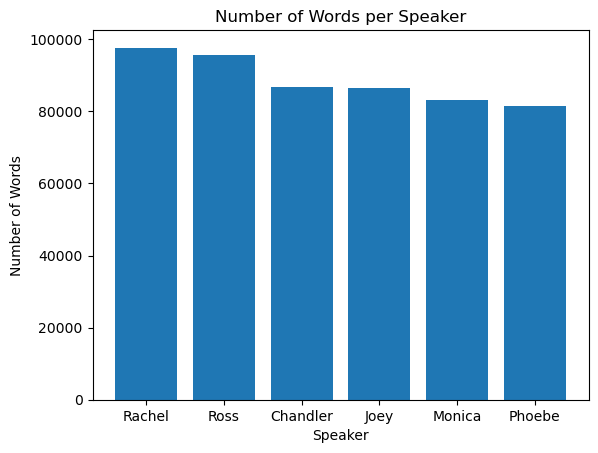

In [73]:
speaker = df_summary['speaker'].apply(lambda x: x.split(" ")[0])
num_words = df_summary['num_words']

plt.bar(speaker, num_words)
plt.xlabel('Speaker')
plt.ylabel('Number of Words')
plt.title('Number of Words per Speaker')

plt.show()

## Who has a wider vocabulary?

In [76]:
# We should lowercase the text in order to avoid adding the same words when they are upper or lowercase
df_simple = df_main_char[['speaker','text']]
df_simple['text'] = df['text'].apply(lambda x: x.lower())
df_simple

speaker                                               text
0       Monica Geller  there's nothing to tell! he's just some guy i ...
1      Joey Tribbiani  c'mon, you're going out with the guy! there's ...
2       Chandler Bing  all right joey, be nice. so does he have a hum...
3       Phoebe Buffay                           wait, does he eat chalk?
5       Phoebe Buffay  just, 'cause, i don't want her to go through w...
...               ...                                                ...
67368   Chandler Bing                            oh, it's gonna be okay.
67369    Rachel Green  do you guys have to go to the new house right ...
67370   Monica Geller                                  we got some time.
67371    Rachel Green                   okay, should we get some coffee?
67372   Chandler Bing                                       sure. where?

[51312 rows x 2 columns]

In [77]:
# Create a new DataFrame to store the count of unique words for each speaker
unique_words_df = pd.DataFrame(columns=['speaker', 'unique_words'])

# Iterate through the unique speakers
for speaker in df_simple['speaker'].unique():
    # Filter the DataFrame for the current speaker
    speaker_df = df_simple[df_simple['speaker'] == speaker]

    # Concatenate all the text and split it into words
    words = ' '.join(speaker_df['text']).split()

    # Count the unique words
    unique_word_count = len(set(words))

    # Append the result to the unique_words_df DataFrame
    unique_words_df = unique_words_df.append({'speaker': speaker, 'unique_words': unique_word_count}, ignore_index=True)

# Sort the unique_words_df DataFrame by the 'unique_words' column in descending order
sorted_unique_words_df = unique_words_df.sort_values('unique_words', ascending=False)

# Display the sorted DataFrame
sorted_unique_words_df

speaker unique_words
4     Ross Geller        11571
2   Chandler Bing        11183
5    Rachel Green        10634
1  Joey Tribbiani        10601
3   Phoebe Buffay        10466
0   Monica Geller         9970

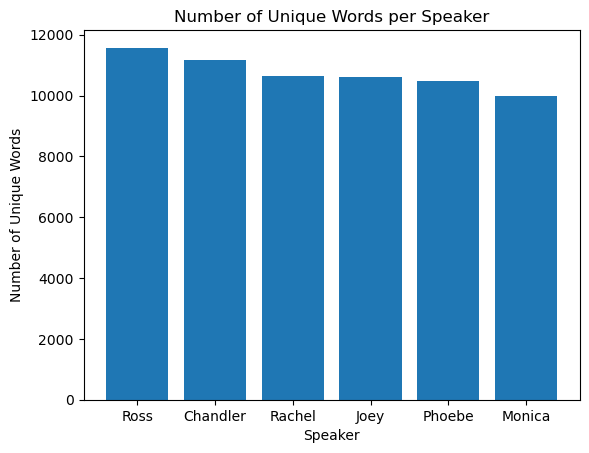

In [78]:
# Get the speaker and unique_words columns from the sorted DataFrame
speaker = sorted_unique_words_df['speaker'].apply(lambda x: x.split(" ")[0])
unique_words = sorted_unique_words_df['unique_words']

plt.bar(speaker, unique_words)
plt.xlabel('Speaker')
plt.ylabel('Number of Unique Words')
plt.title('Number of Unique Words per Speaker')

plt.show()

## Which pair of characters interact the most?

In [79]:
# Create an empty graph
G = nx.Graph()
# Group the DataFrame by conversation_id
grouped = df_main_char.groupby('conversation_id')

for conversation_id, conversation_df in grouped:
    # Get the unique speakers in the conversation
    speakers = conversation_df['speaker'].unique()

    # Iterate through all pairs of speakers in the conversation
    for speaker1, speaker2 in itertools.combinations(speakers, 2):
        # If the pair of speakers has an edge, increase the edge weight by 1
        if G.has_edge(speaker1, speaker2):
            G[speaker1][speaker2]['weight'] += 1
        # If the pair of speakers doesn't have an edge, create one with weight 1
        else:
            G.add_edge(speaker1, speaker2, weight=1)

In [80]:
# Get the list of edges with their weights
edges_with_weights = [(n1, n2, d['weight']) for n1, n2, d in G.edges(data=True)]

# Sort the edges by their weights in descending order
sorted_edges = sorted(edges_with_weights, key=lambda x: x[2], reverse=True)

# Print the sorted edges with their weights
for n1, n2, weight in sorted_edges:
    print(f"{n1} <-> {n2}: {weight}")

Monica Geller <-> Chandler Bing: 976
Joey Tribbiani <-> Chandler Bing: 925
Ross Geller <-> Rachel Green: 861
Monica Geller <-> Phoebe Buffay: 821
Monica Geller <-> Rachel Green: 798
Phoebe Buffay <-> Rachel Green: 786
Chandler Bing <-> Ross Geller: 754
Joey Tribbiani <-> Rachel Green: 728
Monica Geller <-> Joey Tribbiani: 726
Joey Tribbiani <-> Ross Geller: 722
Joey Tribbiani <-> Phoebe Buffay: 711
Chandler Bing <-> Phoebe Buffay: 703
Chandler Bing <-> Rachel Green: 690
Monica Geller <-> Ross Geller: 683
Phoebe Buffay <-> Ross Geller: 672


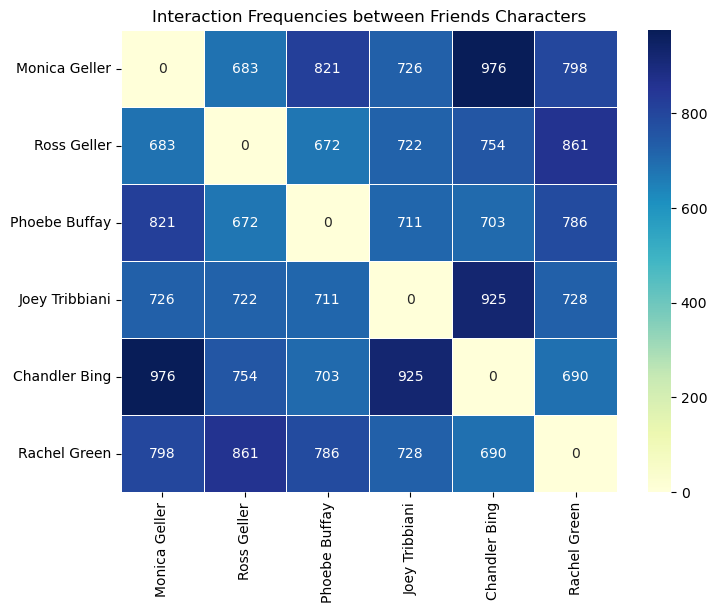

In [81]:
# Create an empty dataframe for the heatmap
heatmap_data = pd.DataFrame(np.zeros((6, 6)), columns=main_characters, index=main_characters)

# Fill in the interaction frequencies from your sorted_edges
for n1, n2, weight in sorted_edges:
    heatmap_data.loc[n1, n2] = weight
    heatmap_data.loc[n2, n1] = weight

# Generate the heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(heatmap_data, annot=True, cmap="YlGnBu", fmt=".0f", linewidths=.5)
plt.title("Interaction Frequencies between Friends Characters")
plt.show()

## What are each character's most common words?

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\mateo\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


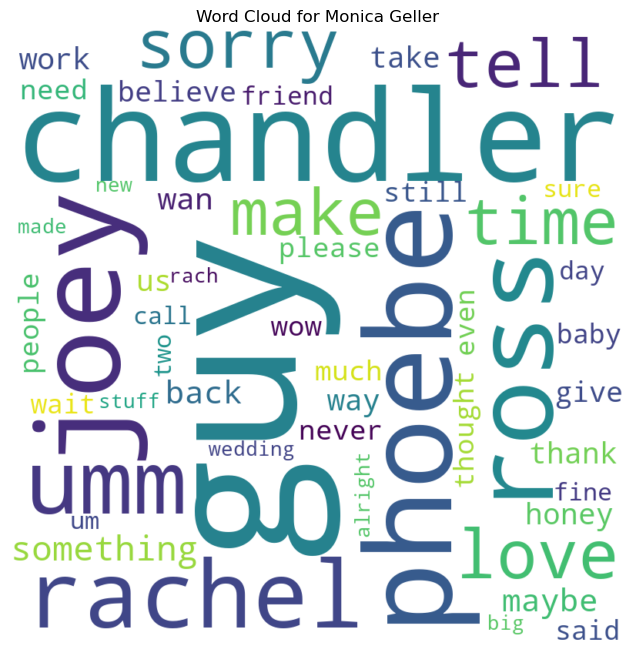

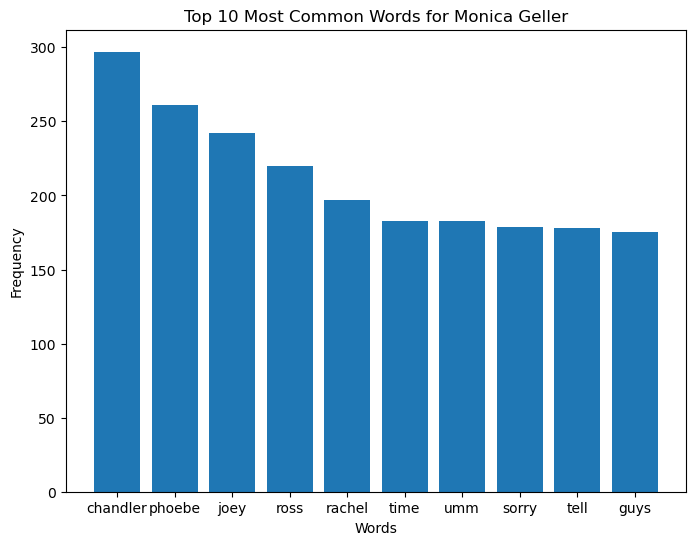

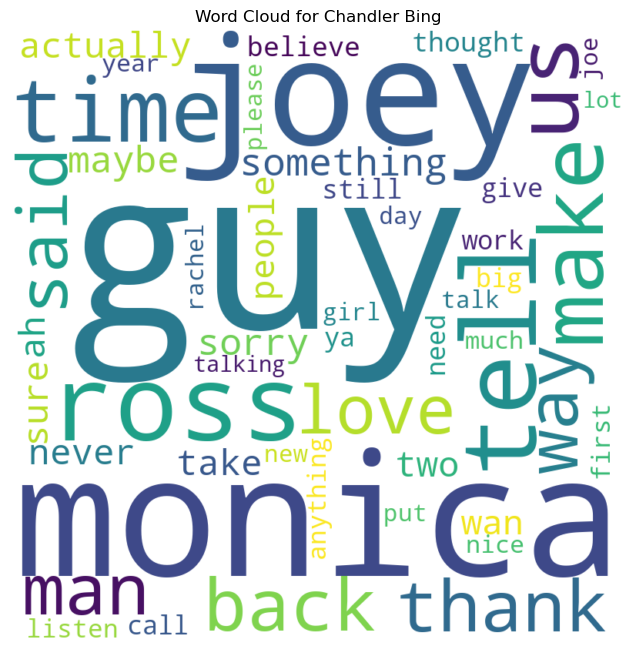

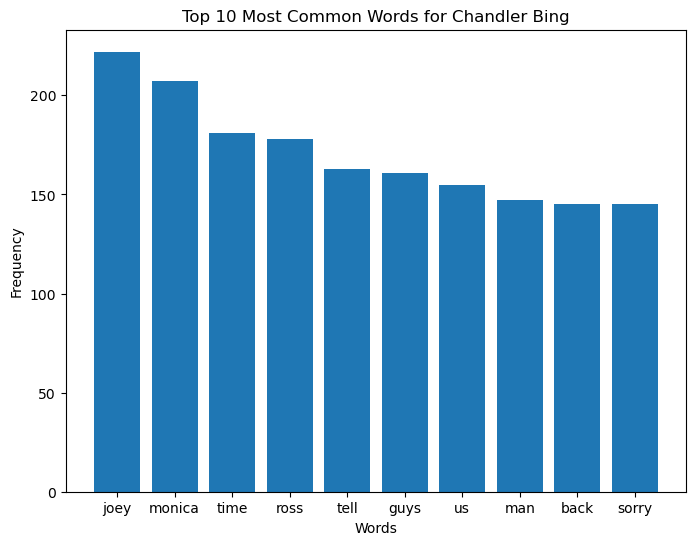

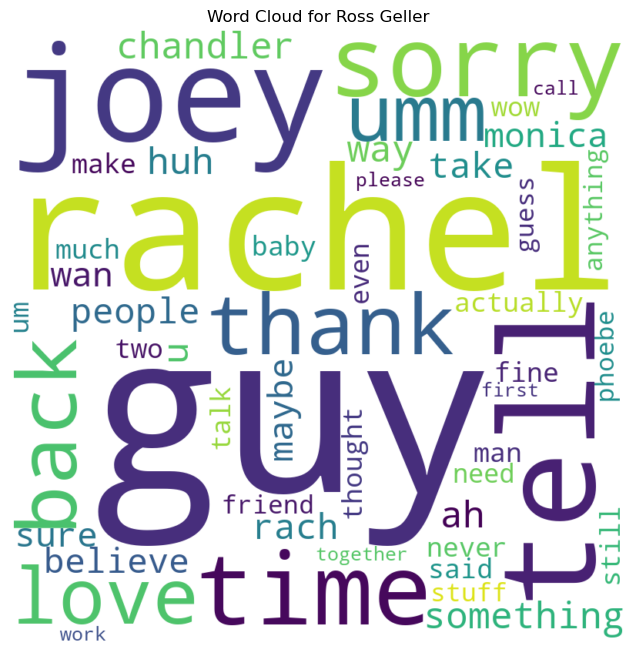

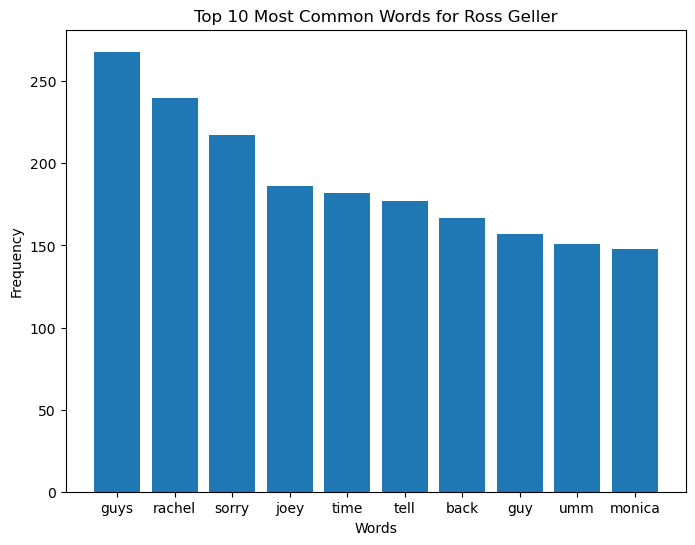

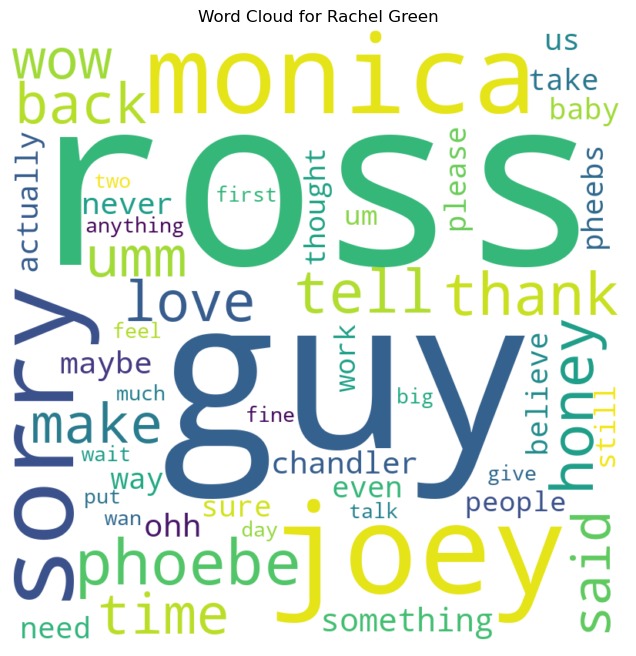

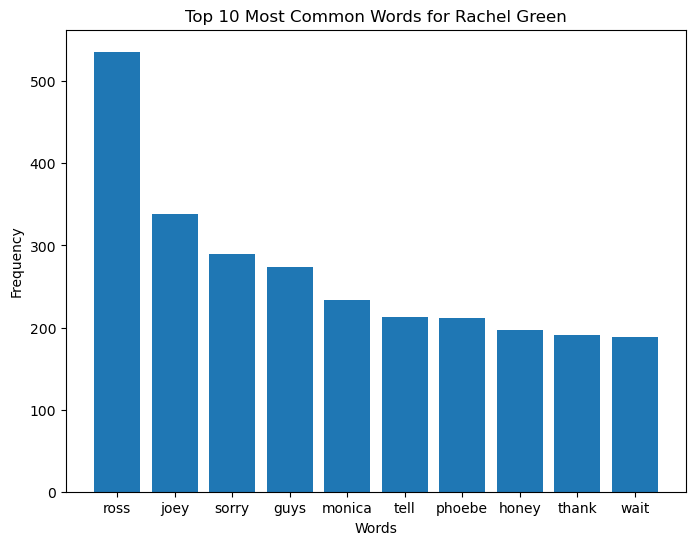

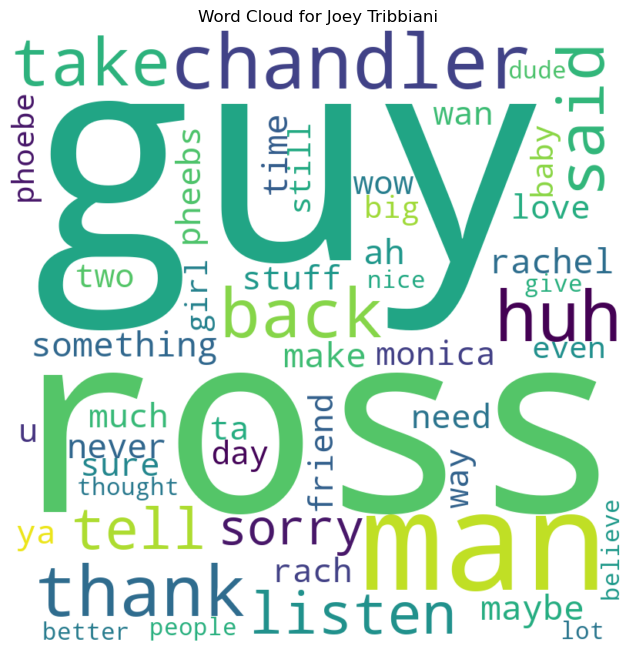

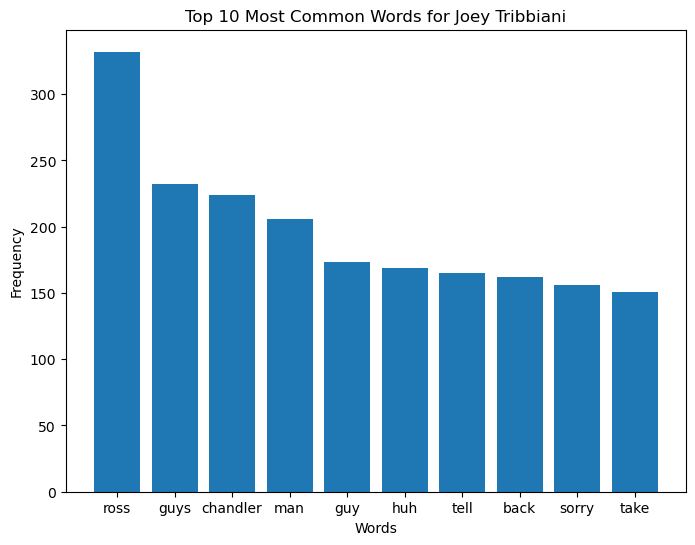

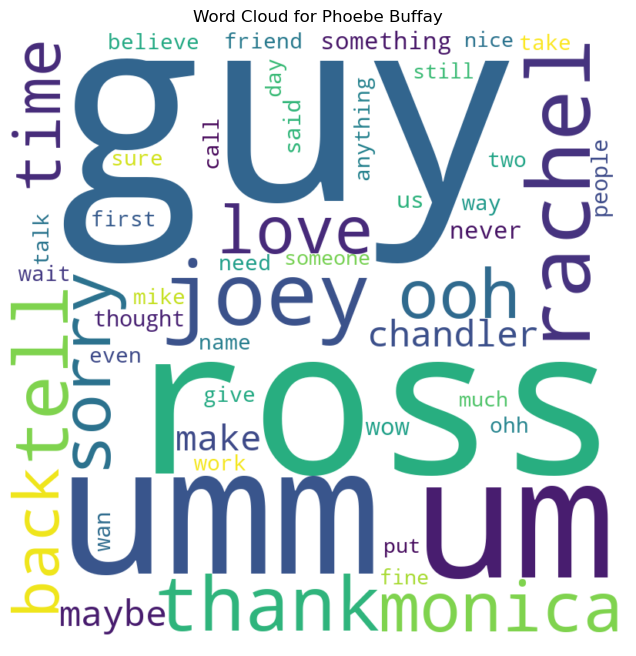

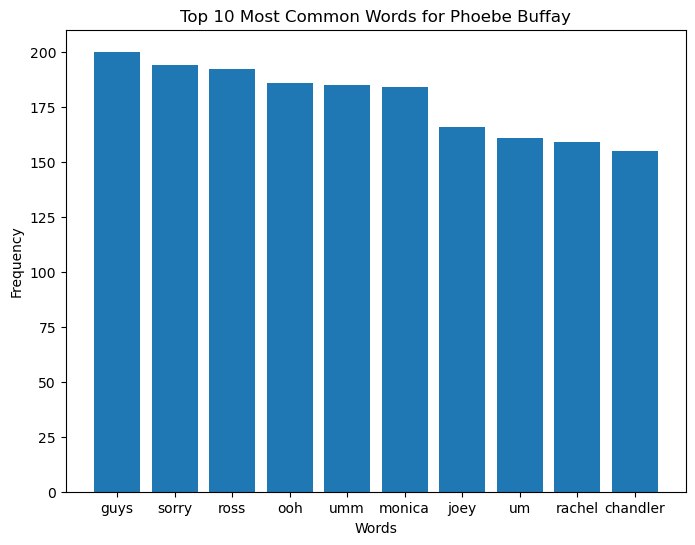

In [82]:
# Make sure to download the stopwords from NLTK
nltk.download('stopwords')
with open('stopwords.txt', 'r') as f:
    custom_stopwords = set(f.read().splitlines())

# Filter the dataframe to keep only the main characters
main_characters = ['Monica Geller', 'Chandler Bing', 'Ross Geller', 'Rachel Green', 'Joey Tribbiani', 'Phoebe Buffay']
df_main_characters = df[df['speaker'].isin(main_characters)]

# Function to preprocess the text and return a list of words
def preprocess_text(text):
    words = nltk.word_tokenize(text.lower())
    words = [word for word in words if word.isalpha()]  # Keep only words containing alphabetical characters
    nltk_stopwords = set(stopwords.words('english'))
    combined_stopwords = nltk_stopwords.union(custom_stopwords)
    words = [word for word in words if word not in combined_stopwords]  # Remove both NLTK and custom stopwords
    return words

# Analyze the most common words for each character
for character in main_characters:
    # Filter the dataframe for the current character
    df_character = df_main_characters[df_main_characters['speaker'] == character]
    
    # Preprocess the text and create a list of words for the character
    words = []
    for text in df_character['text']:
        words.extend(preprocess_text(text))
    
    # Create a word cloud
    wordcloud = WordCloud(width=800, height=800, background_color='white', max_words=50).generate(' '.join(words))
    plt.figure(figsize=(8, 8))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title(f'Word Cloud for {character}')
    plt.show()
    
    # Create a bar chart of the top 10 most common words
    word_counts = Counter(words).most_common(10)
    words, counts = zip(*word_counts)
    plt.figure(figsize=(8, 6))
    plt.bar(words, counts)
    plt.xlabel('Words')
    plt.ylabel('Frequency')
    plt.title(f'Top 10 Most Common Words for {character}')
    plt.show()

## What are each character's most common n-grams

In [83]:
n = 2

def preprocess_text(text, n):
    words = nltk.word_tokenize(text.lower())
    words = [word for word in words if word.isalpha()]
    nltk_stopwords = set(stopwords.words('english'))
    combined_stopwords = nltk_stopwords.union(custom_stopwords)
    words = [word for word in words if word not in combined_stopwords]

    ngrams = list(nltk.ngrams(words, n))
    
    return words, ngrams

def get_top_k_n_grams(k,n):
    word_counts = defaultdict(Counter)
    ngram_counts = defaultdict(Counter)

    for _, row in df_main_characters.iterrows():
        speaker = row['speaker']
        text = row['text']
        words, ngrams = preprocess_text(text, n)
        word_counts[speaker].update(words)
        ngram_counts[speaker].update(ngrams)

    # Display most common n-grams for each character
    for character, ngram_counter in ngram_counts.items():
        print(f"{character}'s most common {n}-grams:")
        for ngram, count in ngram_counter.most_common(k):
            print(f"  {ngram}: {count}")
        print()

get_top_k_n_grams(10,2)

Monica Geller's most common 2-grams:
  ('wait', 'minute'): 36
  ('high', 'school'): 22
  ('wait', 'wait'): 20
  ('big', 'deal'): 18
  ('mom', 'dad'): 17
  ('getting', 'married'): 17
  ('last', 'night'): 16
  ('tell', 'us'): 12
  ('thank', 'much'): 12
  ('first', 'time'): 12

Joey Tribbiani's most common 2-grams:
  ('wait', 'minute'): 29
  ('big', 'deal'): 28
  ('joey', 'tribbiani'): 28
  ('last', 'night'): 24
  ('days', 'lives'): 23
  ('wait', 'wait'): 22
  ('tell', 'ya'): 22
  ('whoa', 'whoa'): 21
  ('monica', 'chandler'): 18
  ('take', 'care'): 16

Chandler Bing's most common 2-grams:
  ('last', 'night'): 25
  ('big', 'deal'): 24
  ('wait', 'minute'): 24
  ('joey', 'joey'): 19
  ('chandler', 'bing'): 18
  ('last', 'time'): 15
  ('new', 'york'): 15
  ('every', 'time'): 12
  ('first', 'time'): 11
  ('next', 'time'): 11

Phoebe Buffay's most common 2-grams:
  ('la', 'la'): 32
  ('wait', 'wait'): 28
  ('smelly', 'cat'): 24
  ('last', 'night'): 19
  ('sorry', 'sorry'): 19
  ('ooh', 'ooh')

In [ ]:
get_top_k_n_grams(10,5)

# Related work

